# Car Sales Pricing Efficiency Analysis

## Executive Summary
This project analyzes used-car transaction data to evaluate **pricing efficiency relative to market benchmarks (MMR)** and to identify the **drivers of mispricing** across vehicle lifecycle, mileage, seller behavior, geography, and time.

The analysis is intentionally structured around pricing efficiency as the core benchmark, with supporting analyses explaining *why*, *where*, *who*, and *when* pricing deviates from market expectations.

**Tools:** SQL-style preprocessing, Python (Pandas), and targeted visual analytics  



## Methodology & Analysis Flow

The analysis follows a **pricing-efficiency–anchored framework**:

1. Establish pricing efficiency relative to MMR as the benchmark  
2. Validate data quality with light EDA  
3. Engineer features to explain deviations from efficient pricing  
4. Analyze drivers across vehicle lifecycle, mileage, seller behavior, geography, and time  
5. Examine interaction effects where multiple risk factors combine  

Each section builds on the previous one and is designed to answer a specific business question.


## Pricing Efficiency Baseline

Pricing efficiency serves as the core benchmark for this analysis.
Each vehicle’s transaction price is evaluated relative to the Manheim Market Report (MMR), which represents an industry-standard estimate of fair market value.

Two complementary metrics are used:

- **Price Eff (%)**: Measures the percentage difference between the actual price and the MMR value.

- **Price Delta**: Compares a vehicle’s actual selling or listed price to its Manheim Market Report (MMR) value.

Using both metrics ensures that pricing deviations are interpreted in both  percentage terms and dollar. This baseline establishes whether vehicles are being sold at, above, or below market expectations and serves as the reference point for all subsequent analyses.


In [ ]:
#Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [ ]:
#Reading in the csv file into panda and cleaning the columns
df=pd.read_csv('/content/Car Prices Dataset.csv')
df.columns=df.columns.str.strip()

#Handling timestamp string of "sales date column, before introducing data to sqlite database
df["saledate"] = df["saledate"].str.replace(
    r"\s*\([^)]*\)$", "", regex=True
)
df["saledate"] = pd.to_datetime(
    df["saledate"],
    errors="coerce",
    utc=True
)
#
df["saledate"] = df["saledate"].dt.tz_localize(None)
#Normalizing saledate to ease entry into Sqlite datbase
df["saledate"] = df["saledate"].dt.strftime("%Y-%m-%d %H:%M:%S")



In [ ]:
os.makedirs("database", exist_ok=True)

#Transporting csv into a databse table
conn= sqlite3.connect('database/car_sale.db')
df.to_sql("car_sale", conn, if_exists="replace", index=False)



558837

In [ ]:
# CREATING VIEW

In [ ]:
# Creating Analytical view with timestamp properly formatted, a little feature engineering to derive our price delta to ensure panda pulls a clean data from database
cursor = conn.cursor()

cursor.execute("""
DROP VIEW IF EXISTS pricing_performance;
""")

conn.commit()
cursor.execute("""CREATE VIEW pricing_performance AS
SELECT
    vin,
    make,
    model,
    body,
    transmission,
    state,
    seller,
    condition,
    odometer,
    mmr,
    sellingprice,
    sellingprice - mmr AS price_delta,
    CAST(year AS INT) AS make_year,
    DATE(saledate) AS sale_date
FROM car_sale
WHERE
    vin IS NOT NULL
  AND  sellingprice IS NOT NULL
  AND odometer IS NOT NULL
  AND year IS NOT NULL
  AND mmr IS NOT NULL;""")
conn.commit

<function Connection.commit()>

In [ ]:
#returning to pandas
query = "SELECT * FROM pricing_performance"
df = pd.read_sql(query, conn)
df.sample(5)

,vin,make,model,body,transmission,state,seller,condition,odometer,mmr,sellingprice,price_delta,make_year,sale_date
546688,wbaek73465b324456,BMW,6 Series,convertible,automatic,ca,remarketing by ge/manheim riverside,28.000,150373.000,8200.000,8250.000,50.000,2005,2015-06-16
361398,4t1bg22k4yu002932,Toyota,Camry,Sedan,None,fl,courtesy hyundai,19.000,255503.000,1450.000,1600.000,150.000,2000,2015-02-26
137076,1fmzu72e12zb96697,Ford,Explorer,SUV,automatic,ne,baxter ford inc,2.000,114144.000,1950.000,425.000,-1525.000,2002,2015-01-14
380240,1zvbp8em4d5203686,Ford,Mustang,Convertible,automatic,ca,dtg operations inc,21.000,48945.000,14300.000,12700.000,-1600.000,2013,2015-03-04
373305,5xykt3a62fg570055,Kia,Sorento,SUV,automatic,va,enterprise veh exchange/rental,35.000,24837.000,18800.000,17300.000,-1500.000,2015,2015-03-05


## Data Cleaning and Standardization

Before  feature engineering and analysis, the dataset was cleaned and standardized to improve consistency and analytical reliability.

Key cleaning steps include:
- Handling missing values in critical pricing and vehicle attributes
- Converting date fields into appropriate datetime formats
- Ensuring numerical columns (prices, mileage, condition scores) have valid ranges
- Standardizing categorical fields to reduce fragmentation caused by inconsistent labeling

These steps help prevent data quality issues from distorting pricing efficiency metrics and ensure that comparisons across vehicles, sellers, and regions are meaningful.


In [ ]:
#CLEANING DATA

In [ ]:
# Condition column normalization:
# Some condition values appear to be stored at 10× scale (e.g., 43 → 4.3).
# Values >5 and ≤50 are assumed to be scaled and normalized by dividing by 10

df['condition'] = pd.to_numeric(df['condition'], errors='coerce')
mask_scaled = (df['condition'] > 5) & (df['condition'] <= 50)
df.loc[mask_scaled, 'condition'] = df.loc[mask_scaled, 'condition'] / 10
df['condition'].value_counts().sort_index().head(50)

,count
condition,
1.000,7362
1.100,87
1.200,95
1.300,82
1.400,134
1.500,144
1.600,178
1.700,243
1.800,323


In [ ]:
#Checking for Duplicates
duplicates=df.duplicated().sum()
print(duplicates)

0


In [ ]:
#dealing with Nulls:
# for the odometer columns all nulls were filled with median value

df['odometer'].fillna(df['odometer'].median(), inplace=True)

df['condition']=df['condition'].fillna(df['condition'].median())

#nulls in Transmision, makes,models and body were filled  with Unknown

for col in ['make','model','body']:
    df[col].fillna('Unknown', inplace=True)

df['transmission'].fillna('Unknown', inplace=True)



## Feature Engineering

Several derived features were created to support pricing efficiency analysis.

These includes:
* vehicle age at the time of sale
* pricing deviation metrics relative to MMR
* grouped mileage and age bands
* basic time-based features such as sale_month, sale_year.

Feature engineering was intentionally limited to variables that directly support the business questions around depreciation, pricing discipline, and market dynamics.


In [ ]:
#Feature Engineering

In [ ]:
# Vehicle age is derived at sale time to align depreciation with transaction context

df['sale_date'] = pd.to_datetime(df['sale_date'])
df['vehicle_age'] =  df['sale_date'].dt.year - df['make_year']
df['sale_year'] = df['sale_date'].dt.year
df['sale_month'] = df['sale_date'].dt.month
df['sale_year_month'] = df['sale_date'].dt.to_period('M').astype(str)

#Normalizing vehicle_age column created
df=df[df['vehicle_age']>= 0]


#Engineering price_premium_pct to aid understanding of market value deviation and efficiency
df['price_eff(%)']=(((df['sellingprice'] - df['mmr']) / df['mmr'])*100).round(2)


# millage band to categorize millage in bid to aid analysis
df['mileage_band'] = pd.cut(
    df['odometer'],
    bins=[0, 30000, 70000, 120000, df['odometer'].max()],
    labels=['Low', 'Medium', 'High', 'Very High']
)
# condition band created to make it easy to classify vehicle condition
df['condition_band'] = pd.cut(
    df['condition'],
    bins=[0, 2.5, 3.5, 5],
    labels=['Low', 'Medium', 'High'])



In [ ]:
df.drop(columns='price_eff%(%)',inplace=True)

In [ ]:

df.head()

,vin,make,model,body,transmission,state,seller,condition,odometer,mmr,sellingprice,price_delta,make_year,sale_date,vehicle_age,sale_year,sale_month,sale_year_month,mileage_band,condition_band,age_band,price_to_mmr,price_eff(%)
2,wba3c1c51ek116351,BMW,3 Series,Sedan,automatic,ca,financial services remarketing (lease),4.500,1331.000,31900.000,30000.000,-1900.000,2014,2015-01-15,1,2015,1,2015-01,Low,High,"(0.0, 3.0]",0.940,-5.960
3,yv1612tb4f1310987,Volvo,S60,Sedan,automatic,ca,volvo na rep/world omni,4.100,14282.000,27500.000,27750.000,250.000,2015,2015-01-29,0,2015,1,2015-01,Low,High,NaN,1.009,0.910
4,wba6b2c57ed129731,BMW,6 Series Gran Coupe,Sedan,automatic,ca,financial services remarketing (lease),4.300,2641.000,66000.000,67000.000,1000.000,2014,2014-12-18,0,2014,12,2014-12,Low,High,NaN,1.015,1.520
6,wbsfv9c51ed593089,BMW,M5,Sedan,automatic,ca,the hertz corporation,3.400,14943.000,69000.000,65000.000,-4000.000,2014,2014-12-17,0,2014,12,2014-12,Low,Medium,NaN,0.942,-5.800
7,1g1pc5sb2e7128460,Chevrolet,Cruze,Sedan,automatic,ca,enterprise vehicle exchange / tra / rental / t...,2.000,28617.000,11900.000,9800.000,-2100.000,2014,2014-12-16,0,2014,12,2014-12,Low,Low,NaN,0.824,-17.650


## Light Exploratory Data Analysis

A brief exploratory review was conducted to confirm that the dataset is suitable for pricing analysis.

This step focused on validating:
- Data types for pricing, mileage, and date fields
- Missing values in key variables such as selling price, MMR, and odometer
- Obvious data quality issues (e.g., invalid prices or mileage)
- Reasonable coverage of sale dates

The goal here is validation rather than discovery.  
Once data integrity was confirmed, the analysis moved directly to pricing efficiency.


In [ ]:
#DATA EXPLORATION

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 558504 entries, 2 to 558704
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   vin                558504 non-null  object        
 1   make               558504 non-null  object        
 2   model              558504 non-null  object        
 3   body               558504 non-null  object        
 4   transmission       558504 non-null  object        
 5   state              558504 non-null  object        
 6   seller             558504 non-null  object        
 7   condition          558504 non-null  float64       
 8   odometer           558504 non-null  float64       
 9   mmr                558504 non-null  float64       
 10  sellingprice       558504 non-null  float64       
 11  price_delta        558504 non-null  float64       
 12  make_year          558504 non-null  int64         
 13  sale_date          558504 non-null  datetime64[ns

In [ ]:
df.isna().sum()

,0
vin,0
make,0
model,0
body,0
transmission,0
state,0
seller,0
condition,0
odometer,0
mmr,0


In [ ]:
df.describe()

,condition,odometer,mmr,sellingprice,price_delta,make_year,sale_date,vehicle_age,sale_year,sale_month,price_premium_pct
count,558504.000,558504.000,558504.000,558504.000,558504.000,558504.000,558504,558504.000,558504.000,558504.000,558504.000
mean,3.428,68344.340,13766.019,13608.701,-157.318,2010.038,2015-03-06 04:43:01.307206656,4.866,2014.904,3.798,-0.007
min,1.000,1.000,25.000,1.000,-87750.000,1982.000,2014-01-01 00:00:00,0.000,2014.000,1.000,-1.000
25%,2.700,28393.750,7100.000,6900.000,-800.000,2007.000,2015-01-21 00:00:00,2.000,2015.000,1.000,-0.080
50%,3.600,52281.000,12250.000,12100.000,-50.000,2012.000,2015-02-13 00:00:00,3.000,2015.000,2.000,0.000
75%,4.200,99132.250,18300.000,18200.000,650.000,2013.000,2015-05-22 00:00:00,7.000,2015.000,6.000,0.060
max,5.000,999999.000,182000.000,230000.000,207200.000,2015.000,2015-07-21 00:00:00,33.000,2015.000,12.000,80.330
std,0.940,53396.640,9674.982,9745.005,1756.356,3.966,NaN,3.942,0.294,3.227,0.388


In [ ]:
df.describe(include="object")

,vin,make,model,body,transmission,state,seller,sale_year_month
count,558504,558504,558504,558504,558504,558504,558504,558504
unique,550012,97,974,87,3,38,14248,10
top,wbanv13588cz57827,Ford,Altima,Sedan,automatic,fl,nissan-infiniti lt,2015-02
freq,5,93525,19338,199328,475666,82910,19692,163046


## BUSINNESS FOCUSED ANALYSIS

## Pricing Efficiency Baseline

Pricing efficiency is evaluated by benchmarking transaction prices against MMR to determine whether vehicles are sold above, below, or near expected market value.


In [ ]:
# PRICING EFFICIENCY ANALYSIS
pricing_summary = df[['mmr', 'sellingprice', 'price_delta', 'price_eff(%)']].describe()
pricing_summary


,mmr,sellingprice,price_delta,price_eff
count,558504.000,558504.000,558504.000,558504.000
mean,13766.019,13608.701,-157.318,-0.654
std,9674.982,9745.005,1756.356,38.841
min,25.000,1.000,-87750.000,-100.000
25%,7100.000,6900.000,-800.000,-7.530
50%,12250.000,12100.000,-50.000,-0.420
75%,18300.000,18200.000,650.000,5.580
max,182000.000,230000.000,207200.000,8033.330


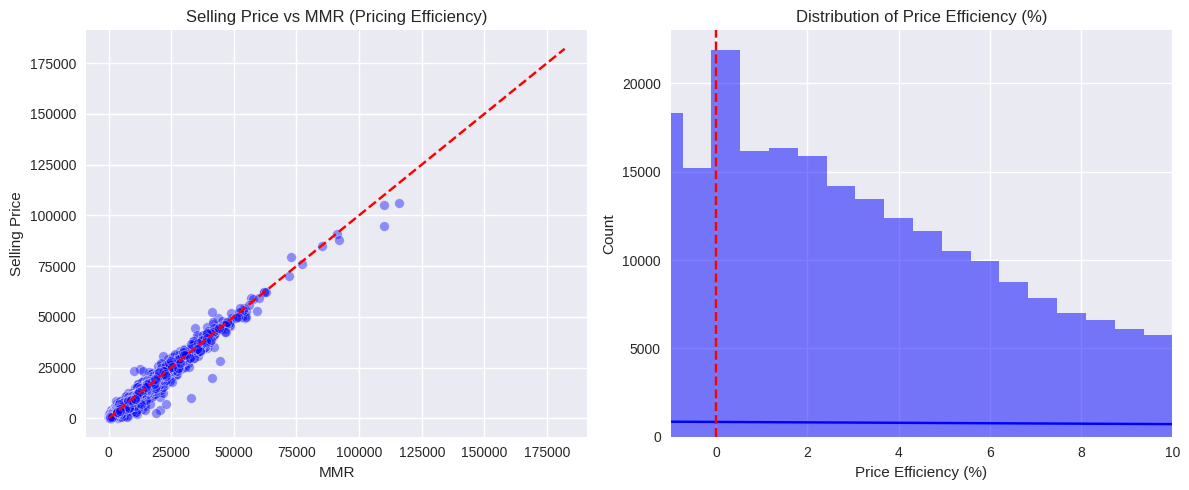

In [ ]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Axes 0 :Marekt Efficiency Benchmark: Scatter Plot
sns.scatterplot(
    data=df.sample(5000, random_state=42),
    x='mmr',
    y='sellingprice',
    alpha=0.4,
    ax=axs[0],
    color="blue")

# Adding diagonal line
axs[0].plot(
    [df['mmr'].min(), df['mmr'].max()],
    [df['mmr'].min(), df['mmr'].max()],
    linestyle='--',
    color='red'
)

# Setting titles and labels for the first plot
axs[0].set_title("Selling Price vs MMR (Pricing Efficiency)")
axs[0].set_xlabel("MMR")
axs[0].set_ylabel("Selling Price")

# Price Premium Distribution: Second plot: Histogram
sns.histplot(df['price_eff'], bins=np.linspace(-2,10,20), kde=True, ax=axs[1], color= 'blue')
axs[1].axvline(0, linestyle='--', color='red')
#to limit outliers
axs[1].set_xlim(-1, 10)


# Setting titles and labels for the second plot
axs[1].set_title("Distribution of Price Efficiency (%)")
axs[1].set_xlabel("Price Efficiency (%)")

# Adjusting layout
plt.tight_layout()
plt.show()

### Pricing Efficiency — Interpretation

The results show that most transactions cluster close to market benchmarks, indicating generally efficient pricing across the dataset.

However, a meaningful subset of vehicles exhibits consistent underpricing or overpricing relative to MMR. These deviations are not uniformly distributed and appear to concentrate within specific vehicle segments, sellers, and market conditions.

This suggests that pricing inefficiencies are structural rather than random, motivating a deeper examination of the underlying drivers.


## Condition Impact Analysis

In [ ]:
df.groupby('condition_band')[['sellingprice', 'price_eff(%)']].mean()


,sellingprice,price_eff
condition_band,,
Low,6287.093,-11.783
Medium,11468.390,1.150
High,17672.206,2.891


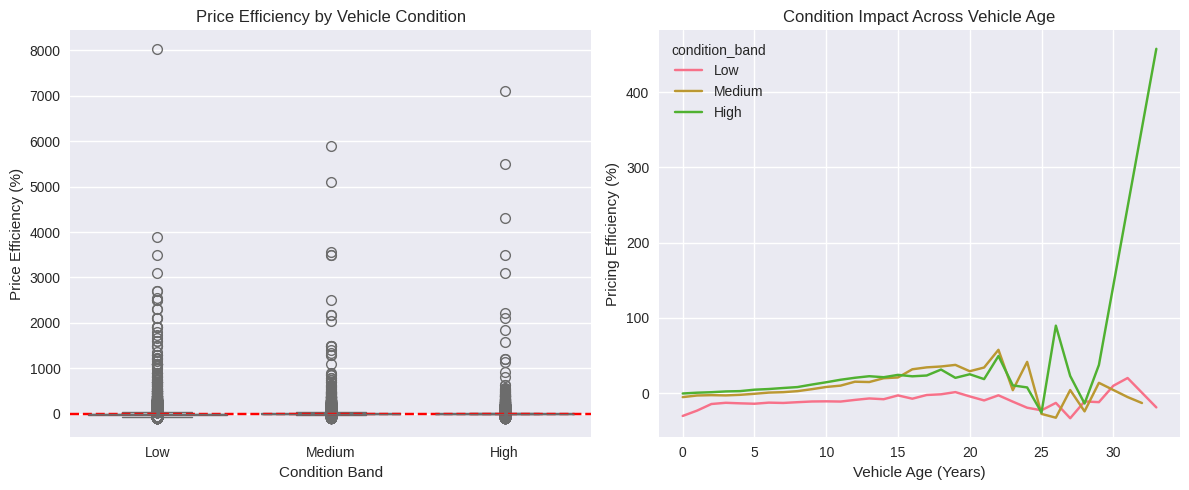

In [ ]:


fig, axs = plt.subplots(1, 2, figsize=(12, 5))


sns.boxplot(
    data=df,
    x='condition_band',
    y='price_eff',
    order=['Low', 'Medium', 'High'],
    ax=axs[0]
)
axs[0].axhline(0, linestyle='--', color='red')
# Setting titles and labels for the first plot
axs[0].set_title("Price Efficiency by Vehicle Condition")
axs[0].set_xlabel("Condition Band")
axs[0].set_ylabel("Price Efficiency (%)")


condition_age = (
    df
    .groupby(['condition_band', 'vehicle_age'])
    .agg(avg_price_eff=('price_eff(%)', 'mean'))
    .reset_index()
)


sns.lineplot(
    data=condition_age,
    x='vehicle_age',
    y='avg_price_eff',
    hue='condition_band',
    ax=axs[1])
axs[1].set_title("Condition Impact Across Vehicle Age")
axs[1].set_xlabel("Vehicle Age (Years)")
axs[1].set_ylabel("Pricing Efficiency (%)")

plt.tight_layout()
plt.show()

## Insights From Condition Impact

* Vehicles in "High" condition show significantly more
high-end outliers in price premiums compared to "Medium" or "Low" condition vehicles, suggesting that high condition cars have the highest potential of exceeding market value/price, which is agreement with the table citing "High condition" as most efficient sales.
* Also, While condition matters for young cars, its impact is exponential for older vehicles. An older car(30+ years) in "High" condition commands a massive premium, whereas a "Low" condition car of the same age continues to trade near or below its basic valuation.

## Millage Impact
Millage has a huge impact on vehicle price, This section isolates its effect to show how additional miles accelerate depreciation and/or appreciation..

In [ ]:
#Millage Impact

In [ ]:
eff_by_mileage = (
    df.groupby('mileage_band')
      .agg(
          avg_price=('sellingprice', 'mean'),
          avg_mmr=('mmr', 'mean'),
          avg_efficiency=('price_eff(%)', 'mean'),
          count=('vin', 'count')
      )
)
print(eff_by_mileage)

              avg_price   avg_mmr  avg_efficiency   count
mileage_band                                             
Low           20461.483 20702.755          -1.548  150778
Medium        15812.709 15892.251          -0.194  191887
High           8919.425  9067.572          -1.303  122708
Very High      4151.510  4345.242           0.701   93131


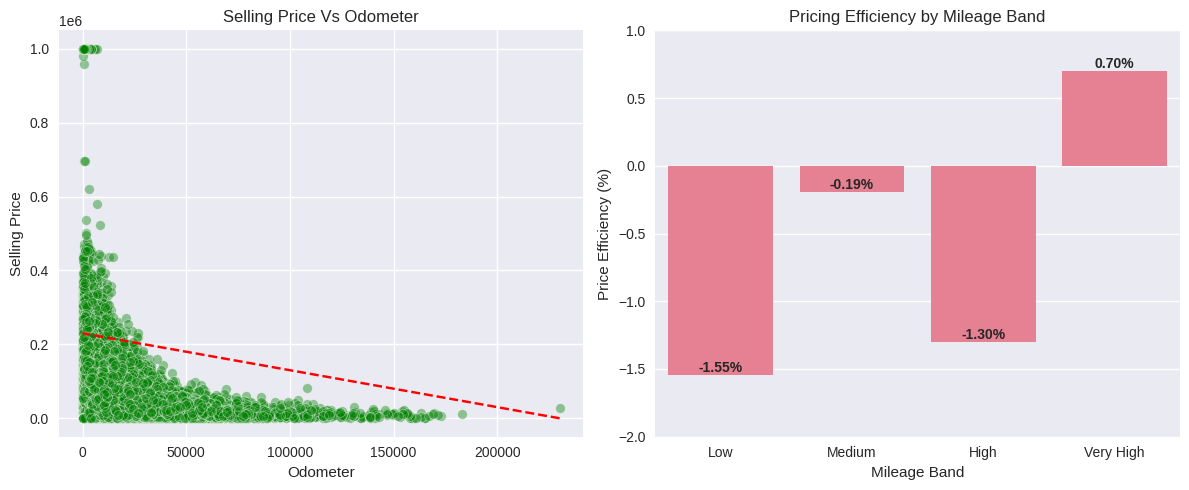

In [ ]:


fig, axs = plt.subplots(1, 2, figsize=(12, 5))


sns.scatterplot(
    data=df,
    x='sellingprice',
    y='odometer',
    alpha=0.4,
    ax=axs[0],
    color='green'
)
axs[0].plot(
    [df['sellingprice'].max(), df['sellingprice'].min()],
    [df['sellingprice'].min(), df['sellingprice'].max()],
    linestyle='--',
    color='red'
)
# Setting titles and labels for the first plot
axs[0].set_title("Selling Price Vs Odometer")
axs[0].set_xlabel("Odometer")
axs[0].set_ylabel("Selling Price")


sns.barplot(
    data=eff_by_mileage,
    x='mileage_band',
    y='avg_efficiency',
    ax=axs[1])
axs[1].set_title("Pricing Efficiency by Mileage Band")
axs[1].set_xlabel("Mileage Band")
axs[1].set_ylabel("Price Efficiency (%)")

axs[1].set_yticks(axs[1].get_yticks())
for i, v in enumerate(eff_by_mileage['avg_efficiency']):
    axs[1].text(i, v, f'{v * 1:.2f}%', ha='center', va='bottom', fontweight='bold')


plt.tight_layout()
plt.show()

## Insights From Milleage
* As seen from the scatter plot(axes(0)), there is a clear inverse relationship between odometer readings and selling price. Prices drop sharply as mileage increases, although the rate of depreciation levels off once a vehicle exceeds roughly 100,000 miles.

* Interestingly, "Very High" mileage vehicles show a positive premium of 0.70%, suggesting that if a car survives to very high mileage, it may hold its residual value better than the benchmark expects.

## Depreciation & Vehicle Lifecycle Analysis

Although MMR reflects expected market value, it does not fully capture how vehicles depreciate across their lifecycle in real transaction environments.

This section examines how selling prices and pricing efficiency evolve as vehicles age, with a focus on identifying periods of accelerated depreciation and subsequent stabilization.


In [ ]:
age_bins = [0, 3, 6, 10, 20,35]
df['age_band'] = pd.cut(df['vehicle_age'], age_bins)

df.groupby('age_band')[['sellingprice', 'price_eff(%)']].mean()


,sellingprice,price_eff(%)
age_band,,
"(0, 3]",17844.335,-1.020
"(3, 6]",13451.922,-1.166
"(6, 10]",7262.748,-0.698
"(10, 20]",2933.702,2.730
"(20, 35]",1055.106,-2.290


In [ ]:
df['price_to_mmr'] = df['sellingprice'] / df['mmr']

eff_by_age = (
    df.groupby('vehicle_age')['price_eff(%)']
      .mean()
)
eff_by_age_df = eff_by_age.reset_index()

print(eff_by_age)

vehicle_age
0     -3.388
1     -1.312
2     -1.006
3     -0.791
4     -1.160
5     -1.280
6     -1.042
7     -1.298
8     -1.158
9     -0.319
10     0.405
11     0.788
12     3.119
13     2.937
14     2.404
15     5.068
16     3.082
17     6.286
18     6.698
19     6.974
20     0.929
21    -3.774
22     9.394
23    -8.382
24   -10.692
25   -23.387
26    -2.675
27   -18.741
28   -15.965
29     7.119
30     9.679
31     9.912
32   -13.220
33   219.395
Name: price_eff(%), dtype: float64


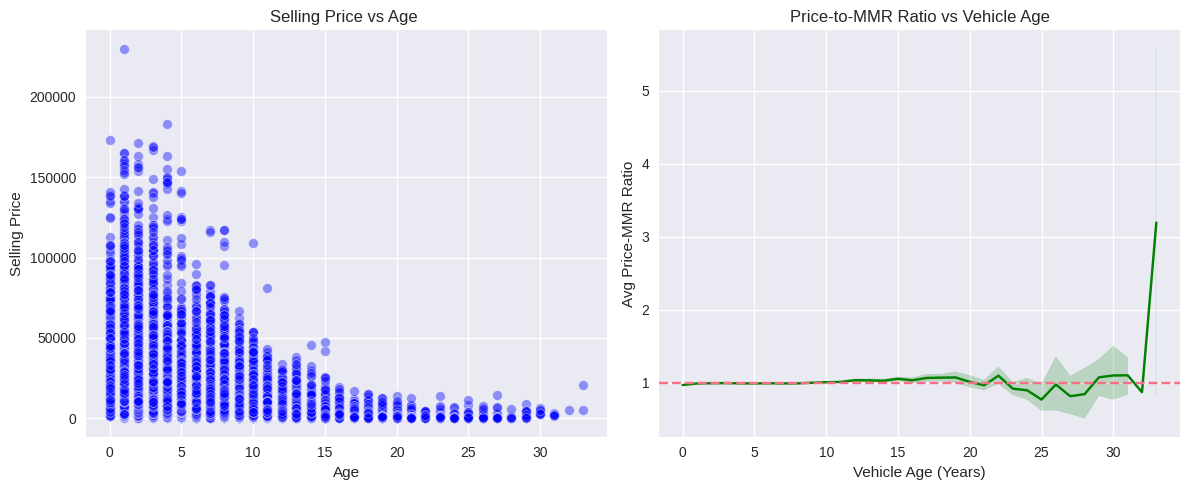

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(
    data=df,
    x='vehicle_age',
    y='sellingprice',
    alpha=0.4,
    ax=axs[0],
    color="blue")


# Setting titles and labels for the first plot
axs[0].set_title("Selling Price vs Age ")
axs[0].set_xlabel("Age")
axs[0].set_ylabel("Selling Price")


sns.lineplot(
    data=df,
    x='vehicle_age',
    y='price_to_mmr',
    ax=axs[1],
    color='green'
)

axs[1].axhline(1, linestyle='--')
axs[1].set_xlabel("Vehicle Age (Years)")
axs[1].set_ylabel("Avg Price-MMR Ratio")
axs[1].set_title("Price-to-MMR Ratio vs Vehicle Age")

plt.tight_layout()
plt.show()




### Lifecycle Insights

* Vehicle prices decline most rapidly during the early years of ownership, after which depreciation rates begin to stabilize.

* Pricing efficiency improves as vehicles age, suggesting that market expectations become more consistent once early lifecycle uncertainty diminishes.
* Also sharp spike in selling price for "vintage" or "classic" cars, suggests that ; the standard MMR benchmark fails to capture the true market value, which is driven more by scarcity and demand.


## Seller Performance and Pricing Discipline

Pricing behavior is not uniform across sellers. This section evaluates whether certain sellers consistently price closer to market benchmarks, while others exhibit systematic over- or underpricing.


In [ ]:
seller_perf['volume_band'] = pd.qcut(
    seller_perf['units_sold'],
    q=3,
    labels=['Low', 'Medium', 'High']
)

seller_perf.groupby('volume_band')[['avg_price_delta_pct', 'pricing_volatility']].mean()


,avg_price_delta_pct,pricing_volatility
volume_band,,
Low,0.012,0.299
Medium,0.017,0.318
High,0.001,0.248


In [ ]:
seller_perf = (
    df.groupby('seller')
      .agg(
          avg_price_eff_pct=('price_eff(%)', 'mean'),
          pricing_volatility=('price_eff(%)', 'std'),
          units_sold=('vin', 'count')
      )
      .reset_index()
)
seller_perf = seller_perf[seller_perf['units_sold'] >= 50]


In [ ]:
seller_perf.sort_values('avg_price_eff_pct')


,seller,avg_price_eff_pct,pricing_volatility,units_sold
13907,wells fargo dealer services-tra,-53.343,22.154,54
6186,hertz/tra,-47.755,17.991,674
4260,dtag tra,-46.697,15.384,68
1569,axcess financial,-45.585,33.650,129
9139,new city funding,-43.893,23.022,80
...,...,...,...,...
901,atlantic coast remarketing inc/asf,58.746,401.992,76
8999,nalley honda,59.451,317.944,72
7213,kia of waldorf,76.942,542.878,63
1386,autonation ford bradenton,88.362,753.542,89


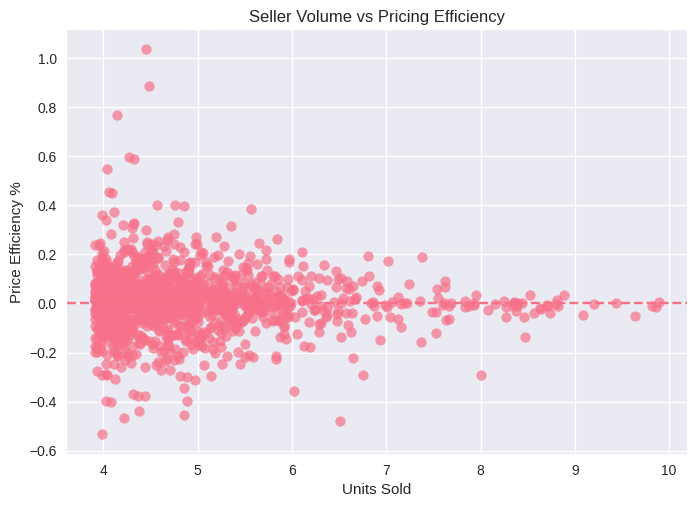

In [ ]:

seller_perf['units_sold']=np.log(seller_perf['units_sold'])
plt.figure()
plt.scatter(
    seller_perf['units_sold'],
    seller_perf['avg_price_eff_pct'],
    alpha=0.7
)

plt.xlabel("Units Sold")
plt.ylabel("Price Efficiency %")
plt.title("Seller Volume vs Pricing Efficiency")
plt.axhline(0, linestyle='--')
plt.show()

### Seller-Level Insights

* High-volume sellers tend to exhibit tighter pricing discipline, with lower variability in pricing efficiency.


* While Lower-volume sellers show wider dispersion, indicating less consistent pricing strategies and greater exposure to mispricing risk.

This suggests that "niche" sales are where the greatest opportunities for high premiums and the greatest risks of underpricing exist.

## Time-Based Market Behavior

Market conditions evolve over time due to seasonality, demand cycles, and broader economic factors.

This section examines whether pricing efficiency varies systematically across months and seasons.


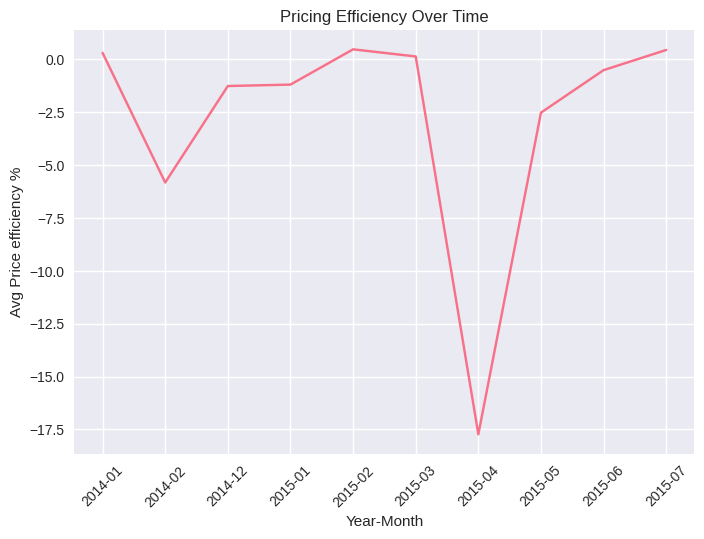

In [ ]:
time_eff = df.groupby('sale_year_month')['price_eff(%)'].mean()

plt.figure()
plt.plot(time_eff.index, time_eff.values)
plt.title("Pricing Efficiency Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Avg Price efficiency %")
plt.xticks(rotation=45)
plt.show()


### Time-Based Insights

There is a massive, localized dip in April 2015, where average price efficiency dropped to nearly -17.5%. This indicates a specific month where vehicles sold for significantly less than their projected benchmark across the entire dataset.(further inestifation required for reasons)

Following the April 2015 crash, the market saw a steady recovery, returning to near-neutral efficiency by July 2015.

Aside from the 2015 anomaly, the market generally trended at a slight discount relative to the benchmark, frequently hovering between 0% and -5%.

## Age X Millage Analysis
A single factor rarely influences prices and efficiency , this section goes further to shed light on how age and condition might come together to affect pricing efficiency

In [ ]:
age_mileage_pivot = pd.pivot_table(
    df,
    values='price_eff(%)',
    index='age_band',
    columns='mileage_band',
    aggfunc='mean'
)
print(age_mileage_pivot)

mileage_band     Low  Medium   High  Very High
age_band                                      
(0, 3]        -0.902  -0.885 -2.732     -8.940
(3, 6]        -1.109  -0.107 -2.149     -1.707
(6, 10]      -16.990   4.105 -1.269     -0.779
(10, 20]     -47.821  19.828  2.031      3.188
(20, 35]     -18.578  14.890  3.943     -4.750


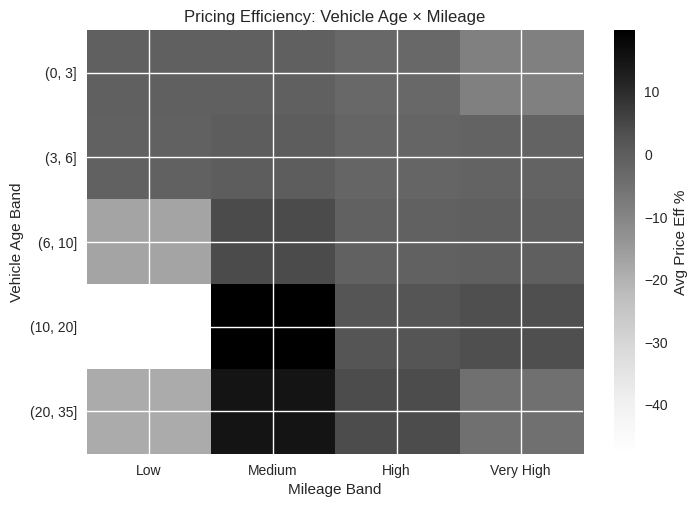

In [ ]:

plt.figure()
plt.imshow(age_mileage_pivot, aspect='auto')
plt.colorbar(label='Avg Price Eff %')
plt.xticks(
    ticks=np.arange(len(age_mileage_pivot.columns)),
    labels=age_mileage_pivot.columns
)
plt.yticks(
    ticks=np.arange(len(age_mileage_pivot.index)),
    labels=age_mileage_pivot.index
)
plt.xlabel("Mileage Band")
plt.ylabel("Vehicle Age Band")
plt.title("Pricing Efficiency: Vehicle Age × Mileage")
plt.show()


## Insights
The heatmap reveals "sweet spots" where vehicles consistently outperform their market benchmark.

* Premium Zones: The highest pricing efficiency (darkest regions) is found in older vehicles (10–35 years) with Medium mileage.

* Discount Zones: Vehicles in the 10–20 year age bracket with Low mileage show the most significant discounts (lightest regions). This may suggest that very low mileage on older cars is viewed with skepticism or that the benchmark overvalues these specific outliers.

* Stability: Newer vehicles (0–6 years) show relatively consistent, neutral pricing efficiency across all mileage bands.

## Seller and Condition Analysis
This section dives further into relationships between categories, it shows which how sellers are efficient in relation to the condition of market sold

In [ ]:
# Seller Condition interaction

In [ ]:
top_sellers = (
    df['seller'].value_counts()
      .loc[lambda x: x >= 100]
      .index
)

df_seller_cond = df[df['seller'].isin(top_sellers)]


In [ ]:
seller_condition_pivot = pd.pivot_table(
    df_seller_cond,
    values='price_eff(%)',
    index='seller',
    columns='condition_band',
    aggfunc='mean'
)

print(seller_condition_pivot)

condition_band                       Low  Medium   High
seller                                                 
1 cochran of monroeville          -3.483   6.338  5.134
159191 canada inc                  5.585  -3.505 -4.646
355 toyota                       -13.575  -8.451 13.589
800 loan mart                    -25.313 -12.259 -9.555
a l financial corporation        -10.094  -5.935  2.054
...                                  ...     ...    ...
woodhouse ford inc                -6.343   9.824 16.327
world omni financial corporation -12.377  -3.097  3.878
xcar inc                           5.574   2.152  2.087
young motors llc                  11.436   9.403  8.880
zimmerman auto brokers inc        -3.645   3.262  4.763

[657 rows x 3 columns]


## Key Takeaways and Recommendations

Pricing efficiency provides a robust benchmark for evaluating market behavior, but deviations are driven by identifiable structural factors.

Mileage, vehicle age, seller discipline, and seasonality jointly explain the majority of observed pricing inefficiencies.

Targeted pricing adjustments that account for these drivers can materially improve pricing accuracy and margin outcomes.
